In [41]:
# config_and_imports.py2
import os
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional, Any, Tuple, Union
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Statsmodels
from statsmodels.tsa.arima.model import ARIMA  # <--- RE-ADDED THIS
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# PyTorch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#TFT
import lightning.pytorch as pl
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import RMSE

warnings.simplefilter("ignore")

# --- CONFIGURATION ---
M5_ROOT = "/kaggle/input/m5-forecasting-accuracy"
STORE_ID = "CA_1"
DEPT_ID = "FOODS_2"
N_SERIES = 10
YEARS = 2
FORECAST_HORIZON_DAYS = 28

TFT_PARAMS_WEEKLY = {
    "gradient_clip_val": 0.1,
    "max_epochs": 20,          # Weekly converges faster, but we can give it more epochs
    "hidden_size": 32,
    "lstm_layers": 2,
    "dropout": 0.1,
    "learning_rate": 0.03,
    "batch_size": 64,          # You can likely increase this since data is smaller
    "context_length": 12,      # Look back 12 weeks (approx 3 months)
    "prediction_length": 4,    # Forecast 4 weeks
    "target_col": "weekly_sales" # Important: Target column name changes
}
TFT_PARAMS_DAILY = {
    "gradient_clip_val": 0.1,
    "max_epochs": 15,          # Adjust based on patience/time
    "hidden_size": 32,         # Hidden dimension
    "lstm_layers": 2,
    "dropout": 0.1,
    "learning_rate": 0.03,
    "batch_size": 64,
    "context_length": 60,      # Look-back window (encoder length)
    "prediction_length": 28,   # Forecast horizon
}

LGB_PARAMS_DAILY = {
    "boosting_type": "gbdt",
    "objective": "tweedie",
    "metric": "rmse",
    "verbose": -1,
    "random_state": 42,
    "force_col_wise": True,
    "learning_rate": 0.06868914676964558,
    "num_leaves": 43,
    "feature_fraction": 0.931668430789315,
    "min_data_in_leaf": 17,
    "tweedie_variance_power": 1.3573314664632754,
}

LSTM_PARAMS_DAILY = {
    "hidden": 64,
    "layers": 2,
    "dropout": 0.1,
    "lr": 0.005,
}


# 2. Weekly Aggregation Strategy Params
LGB_PARAMS_WEEKLY_AGG = {
    "boosting_type": "gbdt",
    "objective": "tweedie",
    "metric": "rmse",
    "verbose": -1,
    "random_state": 42,
    "force_col_wise": True,
    "learning_rate": 0.045280803658806164,
    "num_leaves": 61,
    "feature_fraction": 0.821116140056114,
    "min_data_in_leaf": 46,
    "tweedie_variance_power": 1.4368176832402675,
}

LSTM_PARAMS_WEEKLY_AGG = {
    "hidden": 64,
    "layers": 2,
    "dropout": 0.1,
    "lr": 0.005,
}


# 3. Weekly Rolling Strategy Params
LGB_PARAMS_WEEKLY_ROLL = {
    "boosting_type": "gbdt",
    "objective": "tweedie",
    "metric": "rmse",
    "verbose": -1,
    "random_state": 42,
    "force_col_wise": True,
    "learning_rate": 0.09300550787843843,
    "num_leaves": 62,
    "feature_fraction": 0.9538319704882288,
    "min_data_in_leaf": 32,
    "tweedie_variance_power": 1.3311258880221715,
}

LSTM_PARAMS_WEEKLY_ROLL = {
    "hidden": 64,
    "layers": 2,
    "dropout": 0.1,
    "lr": 0.005,
}

In [42]:
# data_preparation.py
# (No changes needed here, keeping previous implementation)
def load_base_data(m5_root, store_id, dept_id, n_series=20, years=2, min_sale_percent=5.0):
    print(f"Loading data for {store_id} - {dept_id}...")
    sales = pd.read_csv(f"{m5_root}/sales_train_validation.csv")
    calendar = pd.read_csv(f"{m5_root}/calendar.csv")
    prices = pd.read_csv(f"{m5_root}/sell_prices.csv")
    mask = (sales["store_id"] == store_id) & (sales["dept_id"] == dept_id)
    sales = sales[mask].head(n_series).reset_index(drop=True)
    id_cols = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]
    d_cols = [c for c in sales.columns if c.startswith("d_")]
    if years > 0: d_cols = d_cols[-(years * 365):]
    df = sales[id_cols + d_cols].melt(id_vars=id_cols, value_vars=d_cols, var_name="d", value_name="sales")
    sale_pct = df.groupby("id")["sales"].apply(lambda x: (x > 0).mean() * 100)
    active_ids = sale_pct[sale_pct >= min_sale_percent].index
    df = df[df["id"].isin(active_ids)].reset_index(drop=True)
    df = df.merge(calendar, on="d", how="left")
    df["date"] = pd.to_datetime(df["date"])
    df = df.merge(prices, on=["store_id", "item_id", "wm_yr_wk"], how="left")
    df["sell_price"] = df.groupby("id")["sell_price"].ffill().fillna(0)
    return df.sort_values(["id", "date"]).reset_index(drop=True)

def split_time_based(df, cutoff_date):
    train = df[df["date"] < cutoff_date].copy()
    test = df[df["date"] >= cutoff_date].copy()
    return train, test

def get_cutoff_date(df, days_back=28):
    return df["date"].max() - pd.Timedelta(days=days_back - 1)

In [43]:
# feature_engineering.py
# (No changes needed here, keeping previous implementation)
def add_basic_time_features(df):
    df = df.copy()
    df["dow"] = df["date"].dt.dayofweek
    df["day"] = df["date"].dt.day
    df["month"] = df["date"].dt.month
    df["week"] = df["date"].dt.isocalendar().week.astype(int)
    df["dow_sin"] = np.sin(2 * np.pi * df["dow"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dow"] / 7)
    df = df.drop(columns=[c for c in ["d", "weekday"] if c in df.columns])
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        if col == "id": continue
        df[col] = df[col].fillna("Unknown").astype("category").cat.codes
    df["snap_CA"] = df["snap_CA"].fillna(0)
    return df

def add_lags_and_rolls(df, value_col, lags, windows, group_col="id"):
    g = df.groupby(group_col)[value_col]
    for lag in lags: df[f"lag_{lag}"] = g.shift(lag)
    for w in windows:
        df[f"roll_mean_{w}"] = g.transform(lambda x: x.shift(1).rolling(w).mean())
        df[f"roll_std_{w}"] = g.transform(lambda x: x.shift(1).rolling(w).std())
    return df.fillna(0)

def process_daily_features(df):
    df = add_basic_time_features(df)
    df = add_lags_and_rolls(df, "sales", lags=[7, 14, 28], windows=[7, 28])
    return df

def process_weekly_agg_features(df):
    df = df.copy() 
    df["week_start"] = df["date"] - pd.to_timedelta(df["date"].dt.dayofweek, unit='D')
    agg_dict = {"sales": "sum", "sell_price": "mean", "snap_CA": "max"}
    for c in ["event_name_1", "item_id", "cat_id", "dept_id"]:
        if c in df.columns: agg_dict[c] = "first"
    weekly = df.groupby(["id", "week_start"]).agg(agg_dict).reset_index().rename(columns={"sales": "weekly_sales", "week_start": "date"})
    weekly = add_basic_time_features(weekly)
    return add_lags_and_rolls(weekly, "weekly_sales", lags=[1, 2, 4], windows=[4, 8])

def process_rolling_features(df):
    df = add_basic_time_features(df)
    df["roll_sum_7"] = df.groupby("id")["sales"].transform(lambda x: x.rolling(7).sum())
    df = add_lags_and_rolls(df, "sales", lags=[7, 28], windows=[7, 28])
    for l in [1, 2, 3]: df[f"roll_sum_lag_{l}w"] = df.groupby("id")["roll_sum_7"].shift(l*7)
    return df.fillna(0)

In [44]:
# dataset_creation.py
def create_multi_horizon_targets(df, target_col, horizon, unit_step=1, prefix="target_"):
    df = df.copy()
    g = df.groupby("id")[target_col]
    target_names = []
    for h in range(1, horizon + 1):
        col_name = f"{prefix}{h}"
        df[col_name] = g.shift(-h * unit_step)
        target_names.append(col_name)
    return df.dropna(subset=target_names), target_names

In [45]:
# models_lgbm.py
def train_lgbm_direct(train_df, val_df, feature_cols, target_cols, params):
    models = {}
    for tgt in target_cols:
        print(f"  Training LGBM for {tgt}...")
        dtrain = lgb.Dataset(train_df[feature_cols], label=train_df[tgt])
        dval = lgb.Dataset(val_df[feature_cols], label=val_df[tgt], reference=dtrain)
        bst = lgb.train(params, dtrain, num_boost_round=300,
                        valid_sets=[dval], callbacks=[lgb.early_stopping(30, verbose=False), lgb.log_evaluation(0)])
        models[tgt] = bst
    return models

def predict_lgbm(models, latest_features, feature_cols, start_date, freq="D"):
    preds = []
    ids = latest_features["id"].values
    X_feat = latest_features[feature_cols]
    for tgt_name, model in models.items():
        h_idx = int(tgt_name.split("_")[-1]) 
        y_pred = np.maximum(model.predict(X_feat), 0)
        
        if freq == "W": delta = pd.Timedelta(weeks=h_idx - 1)
        elif freq == "7D": delta = pd.Timedelta(days=(h_idx * 7) - 1)
        else: delta = pd.Timedelta(days=h_idx - 1)
            
        preds.append(pd.DataFrame({
            "id": ids, "date": start_date + delta, "horizon_idx": h_idx,
            "forecast": y_pred, "model_type": "LGBM"
        }))
    return pd.concat(preds, ignore_index=True)

In [46]:
# models_stats.py

def forecast_stats_models(
    df: pd.DataFrame,
    freq_str: str,
    target_col: str,
    horizon: int,
    start_date: pd.Timestamp,
    seasonal_period: int = 7
) -> Dict[str, pd.DataFrame]:
    """
    Runs Regular ARIMA (1,1,1), SARIMAX, and ExpSmoothing.
    """
    arima_res = []
    sarimax_res = [] 
    es_res = []
    
    # Iterate through each series
    for sid, sdf in tqdm(df.groupby("id"), desc=f"Stats Models ({freq_str})"):
        # Prepare Univariate Series
        ts = sdf.set_index("date")[target_col].asfreq(freq_str).fillna(0)
        
        # 1. ARIMA (Non-seasonal, fixed order)
        try:
            mod_a = ARIMA(ts, order=(1,1,1)).fit()
            fc_a = mod_a.forecast(horizon)
        except:
            print(f"ARIMA Failed for {sid}: {e}")
            fc_a = pd.Series([ts.iloc[-1]] * horizon)
            
        # 2. SARIMAX (Seasonal)
        try:
            # Basic Seasonal Config: (1,1,1) x (0,1,1, s)
            mod_s = SARIMAX(
                ts, 
                order=(1, 1, 1), 
                seasonal_order=(0, 1, 1, seasonal_period),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)
            fc_s = mod_s.forecast(horizon)
        except:
            print(f"SARIMA Failed for {sid}: {e}")
            fc_s = pd.Series([ts.iloc[-1]] * horizon)

        # 3. Exponential Smoothing (Holt-Winters)
        try:
            mod_e = ExponentialSmoothing(
                ts, 
                trend="add", 
                seasonal="add", 
                seasonal_periods=seasonal_period
            ).fit()
            fc_e = mod_e.forecast(horizon)
        except:
            print(f"ES Failed for {sid}: {e}")
            fc_e = pd.Series([ts.iloc[-1]] * horizon)
            
        # Store Results
        # Ensure forecasts are iterable/list-like
        fc_a = fc_a.values if hasattr(fc_a, "values") else fc_a
        fc_s = fc_s.values if hasattr(fc_s, "values") else fc_s
        fc_e = fc_e.values if hasattr(fc_e, "values") else fc_e

        for h in range(horizon):
            val_a = fc_a[h]
            val_s = fc_s[h]
            val_e = fc_e[h]
            
            # Calculate Forecast Date
            if freq_str.startswith("W"):
                d = start_date + pd.Timedelta(weeks=h)
            elif freq_str == "7D":
                d = start_date + pd.Timedelta(days=(h * 7)) 
            else: # Daily
                d = start_date + pd.Timedelta(days=h)
                
            base = {"id": sid, "date": d, "horizon_idx": h+1}
            
            arima_res.append({**base, "forecast": max(0, val_a), "model_type": "ARIMA"})
            sarimax_res.append({**base, "forecast": max(0, val_s), "model_type": "SARIMAX"})
            es_res.append({**base, "forecast": max(0, val_e), "model_type": "ExpSmoothing"})
            
    return {
        "ARIMA": pd.DataFrame(arima_res),
        "SARIMAX": pd.DataFrame(sarimax_res),
        "ExpSmoothing": pd.DataFrame(es_res)
    }

In [47]:
# models_lstm.py
# --- UPDATED WITH SCALING AND INVERSE TRANSFORM FROM FINETUNE.PY ---

class TimeSeriesDataset(Dataset):
    def __init__(self, df, feature_cols, target_cols, group_col="id", seq_len=28):
        self.samples = []
        # Ensure data is float32 for PyTorch
        # We assume df is already scaled at this point
        for _, sub in df.groupby(group_col):
            sub = sub.sort_values("date")
            X = sub[feature_cols].values.astype(np.float32)
            Y = sub[target_cols].values.astype(np.float32)
            
            if len(sub) <= seq_len: continue

            for t in range(len(sub) - seq_len):
                # x_seq: window of features
                # y_target: target at the end of the window (multi-horizon vector)
                self.samples.append((X[t : t+seq_len], Y[t+seq_len-1]))
                
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x), torch.tensor(y)

class LSTMModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64, num_layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])

def scale_dfs(train_df, val_df, f_cols, t_cols):
    """
    Scales features and targets using StandardScaler. 
    Fits on TRAIN, transforms TRAIN and VAL.
    Returns scaled copies of dataframes and the fitted scalers.
    """
    sc_f, sc_t = StandardScaler(), StandardScaler()
    tr_s, va_s = train_df.copy(), val_df.copy()
    
    # Fit and transform Train
    tr_s[f_cols] = sc_f.fit_transform(train_df[f_cols])
    tr_s[t_cols] = sc_t.fit_transform(train_df[t_cols])
    
    # Transform Validation (using train stats)
    va_s[f_cols] = sc_f.transform(val_df[f_cols])
    va_s[t_cols] = sc_t.transform(val_df[t_cols])
    
    return tr_s, va_s, sc_t, sc_f

def run_lstm_pipeline(
    train_df: pd.DataFrame, 
    val_df: pd.DataFrame, 
    full_df: pd.DataFrame,
    feature_cols: List[str], 
    target_cols: List[str],
    start_date: pd.Timestamp,
    params: Dict,
    freq: str = "D"
) -> pd.DataFrame:
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    SEQ_LEN = 28
    
    # Extract params
    hidden = params.get("hidden", 64)
    layers = params.get("layers", 2)
    drp = params.get("dropout", 0.1)
    lr = params.get("lr", 0.005)
    
    print(f"  [LSTM] Scaling Data...")
    # 1. Scale Data (Train/Val)
    # We use a helper to scale the full_df later for prediction
    tr_s, va_s, sc_t, sc_f = scale_dfs(train_df, val_df, feature_cols, target_cols)

    # 2. Prepare Datasets
    ds_train = TimeSeriesDataset(tr_s, feature_cols, target_cols, seq_len=SEQ_LEN)
    # We don't strictly need ds_val for the training loop in this script, 
    # but could use it for early stopping if expanded.
    
    if len(ds_train) == 0:
        print("Not enough data for LSTM.")
        return pd.DataFrame()

    loader = DataLoader(ds_train, batch_size=64, shuffle=True)
    
    # 3. Setup Model
    model = LSTMModel(len(feature_cols), len(target_cols), hidden, layers, drp).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.MSELoss()
    
    print(f"  [LSTM] Training ({freq}) | Params: {params}")
    # Increased epochs slightly to allow convergence with scaled data
    for ep in range(5): 
        model.train()
        losses = []
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = crit(model(x), y)
            if not torch.isnan(loss):
                loss.backward()
                # Gradient clipping (optional but good for LSTMs)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                opt.step()
                losses.append(loss.item())
        print(f"  Epoch {ep+1} Loss: {np.mean(losses):.4f}")
        
    # 4. Predict
    model.eval()
    preds = []
    
    # Prepare Full Data for Inference
    # We must apply the SAME scaler to the full dataset features
    full_s = full_df.copy()
    full_s[feature_cols] = sc_f.transform(full_df[feature_cols].fillna(0))
    
    # Get last sequence per ID
    last_seqs = full_s.sort_values("date").groupby("id").tail(SEQ_LEN)
    
    with torch.no_grad():
        for sid, sub in last_seqs.groupby("id"):
            if len(sub) < SEQ_LEN: continue
            
            # Prepare sequence
            seq = torch.tensor(sub[feature_cols].values, dtype=torch.float32).unsqueeze(0).to(device)
            
            # Predict (Output is Scaled)
            out_scaled = model(seq).cpu().numpy()[0]
            
            # INVERSE TRANSFORM
            # We must reshape to (1, n_targets) for the scaler
            out = sc_t.inverse_transform(out_scaled.reshape(1, -1))[0]
            out = np.maximum(out, 0) # Clip negatives
            
            for i, val in enumerate(out):
                h_idx = i + 1
                if freq == "W": d = start_date + pd.Timedelta(weeks=i)
                elif freq == "7D": d = start_date + pd.Timedelta(days=(h_idx*7)-1)
                else: d = start_date + pd.Timedelta(days=i)
                
                preds.append({
                    "id": sid, 
                    "date": d, 
                    "horizon_idx": h_idx, 
                    "forecast": val, 
                    "model_type": "LSTM"
                })
                
    return pd.DataFrame(preds)

In [54]:
def print_strategy_metrics(forecast_df, actuals_df, start_date, strategy_name, freq_type):
    """
    Prints numerical error metrics (RMSE, MAE) for a specific strategy.
    """
    print(f"\n>>> PERFORMANCE METRICS: {strategy_name}")
    act_filtered = actuals_df[actuals_df["date"] >= start_date].copy()
    
    # Ensure standardize_to_weekly is available from evaluation.py cell
    std_pred = standardize_to_weekly(forecast_df, freq_type)
    
    act_filtered["week_num"] = ((act_filtered["date"] - start_date).dt.days // 7) + 1
    act_filtered = act_filtered[act_filtered["week_num"] <= 4] 
    weekly_act = act_filtered.groupby(["id", "week_num"])["sales"].sum().reset_index()
    merged = weekly_act.merge(std_pred, on=["id", "week_num"], how="inner")
    
    if merged.empty:
        print("  (No overlapping data for metrics calculation)")
        return

    w_rmse = np.sqrt(np.mean((merged["sales"] - merged["forecast"])**2))
    w_mae = np.mean(np.abs(merged["sales"] - merged["forecast"]))
    
    vol_act = weekly_act.groupby("id")["sales"].sum()
    vol_pred = std_pred.groupby("id")["forecast"].sum()
    common = vol_act.index.intersection(vol_pred.index)
    
    vol_rmse = np.sqrt(np.mean((vol_act[common] - vol_pred[common])**2))
    vol_mae = np.mean(np.abs(vol_act[common] - vol_pred[common]))
    vol_bias = (vol_pred[common] - vol_act[common]).mean()
    
    metrics_df = pd.DataFrame({
        "Metric Level": ["Weekly Aggregated", "Total 28-Day Volume"],
        "RMSE": [w_rmse, vol_rmse], "MAE": [w_mae, vol_mae], "Bias": [np.nan, vol_bias]
    })
    print(metrics_df.to_string(index=False, float_format="%.4f"))
    print("-" * 60)

def plot_inventory_risk(registry, actual_df, start_date):
    """
    2. Inventory Risk Analysis:
    Calculates the % of time each model Under-predicts (Stockout Risk) 
    vs Over-predicts (Overstock Risk). 
    
    Standardizes all models to WEEKLY sums for fair comparison.
    """
    print("\n=== INVENTORY RISK ANALYSIS (Weekly Level) ===")
    results = []
    
    # Prepare Actuals (Weekly)
    act_filtered = actual_df[actual_df["date"] >= start_date].copy()
    act_filtered["week_num"] = ((act_filtered["date"] - start_date).dt.days // 7) + 1
    act_filtered = act_filtered[act_filtered["week_num"] <= 4]
    weekly_actuals = act_filtered.groupby(["id", "week_num"])["sales"].sum().reset_index()
    
    for model_name, (fc_df, freq) in registry.items():
        # Standardize forecast to weekly sum
        std_pred = standardize_to_weekly(fc_df, freq)
        
        # Merge
        merged = weekly_actuals.merge(std_pred, on=["id", "week_num"], how="inner")
        
        if merged.empty: continue
            
        # Calculate Difference: Forecast - Actual
        # diff < 0 means Forecast < Actual (Understock/Stockout)
        # diff > 0 means Forecast > Actual (Overstock)
        diff = merged["forecast"] - merged["sales"]
        
        n_total = len(diff)
        pct_stockout = (diff < 0).sum() / n_total * 100
        pct_overstock = (diff > 0).sum() / n_total * 100
        
        results.append({
            "Model": model_name,
            "Strategy": freq,
            "Stockout Risk (%)": pct_stockout,
            "Overstock Risk (%)": pct_overstock
        })
    
    if not results:
        print("No data available for risk analysis.")
        return

    df_risk = pd.DataFrame(results).sort_values("Stockout Risk (%)")
    
    # Visualization: Stacked Bar Chart
    plt.figure(figsize=(14, 8))
    
    # Create bottom bars (Stockout)
    bar_width = 0.6
    x = range(len(df_risk))
    
    p1 = plt.bar(x, df_risk["Stockout Risk (%)"], width=bar_width, color='#ff9999', label='Stockout Risk (Bias < 0)')
    p2 = plt.bar(x, df_risk["Overstock Risk (%)"], width=bar_width, bottom=df_risk["Stockout Risk (%)"], 
                 color='#66b3ff', label='Overstock Risk (Bias > 0)')
    
    # Add text labels
    for i, (idx, row) in enumerate(df_risk.iterrows()):
        # Stockout label
        if row["Stockout Risk (%)"] > 5:
            plt.text(i, row["Stockout Risk (%)"]/2, f"{row['Stockout Risk (%)']:.1f}%", 
                     ha='center', va='center', color='black', fontsize=9)
        # Overstock label
        if row["Overstock Risk (%)"] > 5:
            y_pos = row["Stockout Risk (%)"] + row["Overstock Risk (%)"]/2
            plt.text(i, y_pos, f"{row['Overstock Risk (%)']:.1f}%", 
                     ha='center', va='center', color='black', fontsize=9)

    plt.xticks(x, df_risk["Model"], rotation=45, ha="right")
    plt.ylabel("Percentage of Weeks (%)")
    plt.title("Inventory Risk Profile: Frequency of Under vs Over Forecasting", fontsize=14)
    plt.legend(loc='upper right')
    plt.axhline(y=50, color='gray', linestyle=':', alpha=0.5) # Reference line at 50%
    plt.tight_layout()
    plt.show()

def plot_separated_forecasts(registry, actual_df, start_date, sample_id=None):
    """
    Creates two separate plots with ROUNDED forecasts and JITTER:
    1. Daily View: Daily Actuals vs Daily Models
    2. Weekly View: Weekly Aggregated Actuals vs Weekly Models vs Aggregated Daily Models
    """
    if not registry:
        print("Registry is empty. No models to plot.")
        return

    # 1. Select Item
    if sample_id is None:
        sample_id = actual_df['id'].sample(1).values[0]
    
    print(f"\n=== VISUALIZING ITEM: {sample_id} ===")
    
    # Filter Actuals for the 28-day horizon
    act_mask = (actual_df['id'] == sample_id) & \
               (actual_df['date'] >= start_date) & \
               (actual_df['date'] < start_date + pd.Timedelta(days=28))
    item_actuals = actual_df[act_mask].sort_values('date')

    # ==========================================
    # PLOT 1: DAILY VIEW
    # ==========================================
    plt.figure(figsize=(14, 6))
    
    # Plot Daily Ground Truth
    plt.plot(item_actuals['date'], item_actuals['sales'], 
             label='Actual Sales (Daily)', color='black', linewidth=2, marker='o', alpha=0.7)
    
    daily_models_exist = False
    colors = sns.color_palette("husl", len(registry))
    
    for i, (model_name, (fc_df, freq)) in enumerate(registry.items()):
        if freq == 'daily':
            daily_models_exist = True
            item_fc = fc_df[fc_df['id'] == sample_id].sort_values('date')
            
            # Round values
            plot_values = item_fc['forecast'].copy().round()
            
            # --- JITTER ADDITION ---
            # Add small random noise (-0.1 to 0.1) so integer overlaps are visible
            jitter = np.random.uniform(-0.1, 0.1, size=len(plot_values))
            
            plt.plot(item_fc['date'], plot_values + jitter, 
                     label=model_name, linewidth=1.5, color=colors[i])

    if daily_models_exist:
        plt.title(f"Daily Granularity: {sample_id} (Rounded + Jitter)")
        plt.ylabel("Sales Units")
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        plt.close()
        print("No daily models found for Plot 1.")

    # ==========================================
    # PLOT 2: WEEKLY VIEW (Aggregated)
    # ==========================================
    plt.figure(figsize=(14, 6))
    
    # 1. Prepare Weekly Ground Truth
    item_actuals = item_actuals.copy()
    item_actuals["week_num"] = ((item_actuals["date"] - start_date).dt.days // 7) + 1
    weekly_actuals = item_actuals.groupby("week_num")["sales"].sum().reset_index()
    
    # Create x-axis labels (Week 1, Week 2, etc.)
    weeks = weekly_actuals["week_num"].values
    
    plt.plot(weeks, weekly_actuals['sales'], 
             label='Actual Sales (Weekly Sum)', color='black', linewidth=3, marker='D', markersize=8, zorder=10)

    # 2. Plot Models (All types standardized to weekly)
    for i, (model_name, (fc_df, freq)) in enumerate(registry.items()):
        item_fc = fc_df[fc_df['id'] == sample_id].copy()
        
        # Aggregate to weekly first
        std_pred = standardize_to_weekly(item_fc, freq)
        
        if not std_pred.empty:
            # Round Aggregated/Weekly Predictions
            std_pred['forecast'] = std_pred['forecast'].round()

            # --- JITTER ADDITION ---
            # Add small random noise (-0.1 to 0.1) so integer overlaps are visible
            jitter = np.random.uniform(-0.1, 0.1, size=len(std_pred))

            style = '--' if freq == 'daily' else '-' 
            marker = 'o' if freq == 'daily' else 's'
            alpha = 0.6 if freq == 'daily' else 1.0 
            
            plt.plot(std_pred['week_num'], std_pred['forecast'] + jitter, 
                     label=f"{model_name} ({'Agg' if freq=='daily' else 'Native'})", 
                     linestyle=style, marker=marker, linewidth=2, color=colors[i], alpha=alpha)

    plt.title(f"Weekly Aggregated View (4 Weeks): {sample_id} (Rounded + Jitter)")
    plt.ylabel("Total Weekly Sales Volume")
    plt.xlabel("Forecast Horizon (Week)")
    plt.xticks([1, 2, 3, 4], ["Week 1", "Week 2", "Week 3", "Week 4"])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [49]:
# evaluation.py
from sklearn.metrics import mean_absolute_error, mean_squared_error

def standardize_to_weekly(df, freq_type):
    df = df.copy()
    if freq_type == "daily":
        df["week_num"] = ((df["horizon_idx"] - 1) // 7) + 1
        return df.groupby(["id", "week_num"])["forecast"].sum().reset_index()
    elif freq_type in ["weekly_agg", "weekly_roll"]:
        df = df.rename(columns={"horizon_idx": "week_num"})
        return df[["id", "week_num", "forecast"]]
    return pd.DataFrame()

def evaluate_all_models(results_registry, actuals_daily, start_date):
    act_daily = actuals_daily[actuals_daily["date"] >= start_date].copy()
    act_daily["week_num"] = ((act_daily["date"] - start_date).dt.days // 7) + 1
    act_daily = act_daily[act_daily["date"] < start_date + pd.Timedelta(days=28)]
    act_weekly = act_daily.groupby(["id", "week_num"])["sales"].sum().reset_index().rename(columns={"sales": "actual"})
    act_28d = act_weekly.groupby("id")["actual"].sum()
    
    metrics = []
    for method_name, (df, ftype) in results_registry.items():
        if df.empty: continue
        row = {"Method": method_name}
        
        # Daily metrics (if applicable)
        if ftype == "daily":
            merged = df.merge(act_daily, on=["id", "date"], how="inner")
            if not merged.empty:
                row["Daily RMSE"] = np.sqrt(mean_squared_error(merged["sales"], merged["forecast"]))
                row["Daily MAE"] = mean_absolute_error(merged["sales"], merged["forecast"])
        else:
            row["Daily RMSE"] = np.nan
            row["Daily MAE"] = np.nan

        # Weekly & Total metrics
        std_pred = standardize_to_weekly(df, ftype)
        merged_w = act_weekly.merge(std_pred, on=["id", "week_num"], how="inner")
        if not merged_w.empty:
            row["Weekly RMSE"] = np.sqrt(mean_squared_error(merged_w["actual"], merged_w["forecast"]))
            row["Weekly MAE"] = mean_absolute_error(merged_w["actual"], merged_w["forecast"])
            
            grp_pred = merged_w.groupby("id")["forecast"].sum()
            common = act_28d.index.intersection(grp_pred.index)
            row["Total 28D RMSE"] = np.sqrt(mean_squared_error(act_28d[common], grp_pred[common]))
            row["Total 28D MAE"] = mean_absolute_error(act_28d[common], grp_pred[common])
            row["Total 28D Bias"] = (grp_pred[common] - act_28d[common]).mean()
        
        metrics.append(row)
    
    res_df = pd.DataFrame(metrics)
    cols = ["Method", "Weekly RMSE", "Weekly MAE", "Total 28D RMSE", "Total 28D MAE", "Total 28D Bias"]
    if "Daily RMSE" in res_df.columns: 
        cols = ["Method", "Daily RMSE", "Daily MAE"] + cols[1:]
    return res_df[cols].sort_values("Weekly RMSE")

In [50]:
# main_execution.py


raw_df = load_base_data(M5_ROOT, STORE_ID, DEPT_ID, N_SERIES, YEARS)
cutoff_date = get_cutoff_date(raw_df, FORECAST_HORIZON_DAYS)
print(f"Data Loaded. Split Date: {cutoff_date}")
registry = {}

# 1. DAILY STRATEGY
print("\n" + "="*40 + "\n STRATEGY 1: Daily Forecast\n" + "="*40)
df_day = process_daily_features(raw_df)
train_day, _ = split_time_based(df_day, cutoff_date)
d_train_lgb, d_targets = create_multi_horizon_targets(train_day, "sales", 28, 1, "day_")
d_val_lgb = d_train_lgb.tail(28 * N_SERIES)
feat_cols_day = [c for c in d_train_lgb.columns if c not in ["id", "date", "sales"] + d_targets]

# 1A. LightGBM (Daily Tuned)
lgb_day_models = train_lgbm_direct(d_train_lgb, d_val_lgb, feat_cols_day, d_targets, LGB_PARAMS_DAILY)
last_day_row = train_day.sort_values("date").groupby("id").tail(1)
fc_lgb_day = predict_lgbm(lgb_day_models, last_day_row, feat_cols_day, cutoff_date, "D")
registry["Daily_LightGBM"] = (fc_lgb_day, "daily")
print_strategy_metrics(fc_lgb_day, raw_df, cutoff_date, "Daily_LightGBM", "daily")

# 1B. Stats Models (Daily) - UNCOMMENTED
stats_res_day = forecast_stats_models(train_day, "D", "sales", 28, cutoff_date, 7)
for m_name, df_res in stats_res_day.items():
    name = f"Daily_{m_name}"
    registry[name] = (df_res, "daily")
    print_strategy_metrics(df_res, raw_df, cutoff_date, name, "daily")

# 1C. LSTM (Daily Tuned)
fc_lstm_day = run_lstm_pipeline(d_train_lgb, d_val_lgb, train_day, feat_cols_day, d_targets, 
                                cutoff_date, LSTM_PARAMS_DAILY, "D")
if not fc_lstm_day.empty:
    registry["Daily_LSTM"] = (fc_lstm_day, "daily")
    print_strategy_metrics(fc_lstm_day, raw_df, cutoff_date, "Daily_LSTM", "daily")


# 2. WEEKLY AGG STRATEGY
print("\n" + "="*40 + "\n STRATEGY 2: Weekly Aggregation\n" + "="*40)
df_week = process_weekly_agg_features(raw_df)
train_week, _ = split_time_based(df_week, cutoff_date)
w_train_lgb, w_targets = create_multi_horizon_targets(train_week, "weekly_sales", 4, 1, "week_")
w_val_lgb = w_train_lgb.tail(4 * N_SERIES)
feat_cols_week = [c for c in w_train_lgb.columns if c not in ["id", "date", "weekly_sales"] + w_targets]

# 2A. LightGBM (Weekly Agg Tuned)
lgb_week_models = train_lgbm_direct(w_train_lgb, w_val_lgb, feat_cols_week, w_targets, LGB_PARAMS_WEEKLY_AGG)
last_week_row = train_week.sort_values("date").groupby("id").tail(1)
fc_lgb_week = predict_lgbm(lgb_week_models, last_week_row, feat_cols_week, cutoff_date, "W")
registry["WeeklyAgg_LightGBM"] = (fc_lgb_week, "weekly_agg")
print_strategy_metrics(fc_lgb_week, raw_df, cutoff_date, "WeeklyAgg_LightGBM", "weekly_agg")

# 2B. Stats Models (Weekly Agg) - UNCOMMENTED
stats_res_week = forecast_stats_models(train_week, "W-MON", "weekly_sales", 4, cutoff_date, 4) 
for m_name, df_res in stats_res_week.items():
    name = f"WeeklyAgg_{m_name}"
    registry[name] = (df_res, "weekly_agg")
    print_strategy_metrics(df_res, raw_df, cutoff_date, name, "weekly_agg")

# 2C. LSTM (Weekly Agg Tuned)
fc_lstm_week = run_lstm_pipeline(w_train_lgb, w_val_lgb, train_week, feat_cols_week, w_targets, 
                                 cutoff_date, LSTM_PARAMS_WEEKLY_AGG, "W")
if not fc_lstm_week.empty:
    registry["WeeklyAgg_LSTM"] = (fc_lstm_week, "weekly_agg")
    print_strategy_metrics(fc_lstm_week, raw_df, cutoff_date, "WeeklyAgg_LSTM", "weekly_agg")


# 3. WEEKLY ROLLING STRATEGY
print("\n" + "="*40 + "\n STRATEGY 3: Weekly Rolling\n" + "="*40)
df_roll = process_rolling_features(raw_df)
train_roll, _ = split_time_based(df_roll, cutoff_date)
r_train_lgb, r_targets = create_multi_horizon_targets(train_roll, "roll_sum_7", 4, 7, "roll_")
r_val_lgb = r_train_lgb.tail(28 * N_SERIES)
feat_cols_roll = [c for c in r_train_lgb.columns if c not in ["id", "date", "sales", "roll_sum_7"] + r_targets]

# 3A. LightGBM (Weekly Roll Tuned)
lgb_roll_models = train_lgbm_direct(r_train_lgb, r_val_lgb, feat_cols_roll, r_targets, LGB_PARAMS_WEEKLY_ROLL)
last_roll_row = train_roll.sort_values("date").groupby("id").tail(1)
fc_lgb_roll = predict_lgbm(lgb_roll_models, last_roll_row, feat_cols_roll, cutoff_date, "7D")
registry["WeeklyRoll_LightGBM"] = (fc_lgb_roll, "weekly_roll")
print_strategy_metrics(fc_lgb_roll, raw_df, cutoff_date, "WeeklyRoll_LightGBM", "weekly_roll")

# 3B. Stats Models (Weekly Roll) - UNCOMMENTED
stats_res_roll = forecast_stats_models(train_roll, "D", "roll_sum_7", 28, cutoff_date, 7)
for m_name, df_res in stats_res_roll.items():
    mask = df_res["horizon_idx"].isin([7, 14, 21, 28])
    df_subset = df_res[mask].copy()
    df_subset["horizon_idx"] = df_subset["horizon_idx"] // 7
    name = f"WeeklyRoll_{m_name}"
    registry[name] = (df_subset, "weekly_roll")
    print_strategy_metrics(df_subset, raw_df, cutoff_date, name, "weekly_roll")

# 3C. LSTM (Weekly Roll Tuned)
fc_lstm_roll = run_lstm_pipeline(r_train_lgb, r_val_lgb, train_roll, feat_cols_roll, r_targets, 
                                 cutoff_date, LSTM_PARAMS_WEEKLY_ROLL, "7D")
if not fc_lstm_roll.empty:
    registry["WeeklyRoll_LSTM"] = (fc_lstm_roll, "weekly_roll")
    print_strategy_metrics(fc_lstm_roll, raw_df, cutoff_date, "WeeklyRoll_LSTM", "weekly_roll")

# Final Board
actuals = raw_df[raw_df["date"] >= cutoff_date].copy()
leaderboard = evaluate_all_models(registry, actuals, cutoff_date)
print("\n" + "="*80 + f"\n{'FINAL LEADERBOARD SUMMARY':^80}\n" + "="*80)
print(leaderboard.to_string(index=False, float_format="%.4f"))
print("="*80)

Loading data for CA_1 - FOODS_2...
Data Loaded. Split Date: 2016-03-28 00:00:00

 STRATEGY 1: Daily Forecast
  Training LGBM for day_1...
  Training LGBM for day_2...
  Training LGBM for day_3...
  Training LGBM for day_4...
  Training LGBM for day_5...
  Training LGBM for day_6...
  Training LGBM for day_7...
  Training LGBM for day_8...
  Training LGBM for day_9...
  Training LGBM for day_10...
  Training LGBM for day_11...
  Training LGBM for day_12...
  Training LGBM for day_13...
  Training LGBM for day_14...
  Training LGBM for day_15...
  Training LGBM for day_16...
  Training LGBM for day_17...
  Training LGBM for day_18...
  Training LGBM for day_19...
  Training LGBM for day_20...
  Training LGBM for day_21...
  Training LGBM for day_22...
  Training LGBM for day_23...
  Training LGBM for day_24...
  Training LGBM for day_25...
  Training LGBM for day_26...
  Training LGBM for day_27...
  Training LGBM for day_28...

>>> PERFORMANCE METRICS: Daily_LightGBM
       Metric Level

Stats Models (D): 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]



>>> PERFORMANCE METRICS: Daily_ARIMA
       Metric Level   RMSE    MAE    Bias
  Weekly Aggregated 2.6093 2.1647     NaN
Total 28-Day Volume 6.8743 6.3272 -0.4519
------------------------------------------------------------

>>> PERFORMANCE METRICS: Daily_SARIMAX
       Metric Level   RMSE    MAE    Bias
  Weekly Aggregated 2.6636 2.1794     NaN
Total 28-Day Volume 7.2144 6.4782 -0.4447
------------------------------------------------------------

>>> PERFORMANCE METRICS: Daily_ExpSmoothing
       Metric Level   RMSE    MAE    Bias
  Weekly Aggregated 2.6344 2.1044     NaN
Total 28-Day Volume 7.0347 6.2622 -1.1075
------------------------------------------------------------
  [LSTM] Scaling Data...
  [LSTM] Training (D) | Params: {'hidden': 64, 'layers': 2, 'dropout': 0.1, 'lr': 0.005}
  Epoch 1 Loss: 0.8378
  Epoch 2 Loss: 0.7842
  Epoch 3 Loss: 0.7552
  Epoch 4 Loss: 0.7248
  Epoch 5 Loss: 0.6957

>>> PERFORMANCE METRICS: Daily_LSTM
       Metric Level   RMSE    MAE    Bias
  Weekly

Stats Models (W-MON): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]



>>> PERFORMANCE METRICS: WeeklyAgg_ARIMA
       Metric Level   RMSE    MAE   Bias
  Weekly Aggregated 2.9728 2.4361    NaN
Total 28-Day Volume 8.3913 7.5836 0.3385
------------------------------------------------------------

>>> PERFORMANCE METRICS: WeeklyAgg_SARIMAX
       Metric Level   RMSE    MAE   Bias
  Weekly Aggregated 2.7854 2.2699    NaN
Total 28-Day Volume 7.4174 6.9876 0.2794
------------------------------------------------------------

>>> PERFORMANCE METRICS: WeeklyAgg_ExpSmoothing
       Metric Level   RMSE    MAE    Bias
  Weekly Aggregated 2.7437 2.0994     NaN
Total 28-Day Volume 7.3484 6.4011 -0.8345
------------------------------------------------------------
  [LSTM] Scaling Data...
  [LSTM] Training (W) | Params: {'hidden': 64, 'layers': 2, 'dropout': 0.1, 'lr': 0.005}
  Epoch 1 Loss: 0.9486
  Epoch 2 Loss: 0.7383
  Epoch 3 Loss: 0.6548
  Epoch 4 Loss: 0.6312
  Epoch 5 Loss: 0.5609

>>> PERFORMANCE METRICS: WeeklyAgg_LSTM
       Metric Level    RMSE    MAE    Bi

Stats Models (D): 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]



>>> PERFORMANCE METRICS: WeeklyRoll_ARIMA
       Metric Level   RMSE    MAE    Bias
  Weekly Aggregated 3.0176 2.2262     NaN
Total 28-Day Volume 9.1599 6.2727 -4.0897
------------------------------------------------------------

>>> PERFORMANCE METRICS: WeeklyRoll_SARIMAX
       Metric Level   RMSE    MAE    Bias
  Weekly Aggregated 2.9989 2.2245     NaN
Total 28-Day Volume 9.0395 6.2689 -3.6796
------------------------------------------------------------

>>> PERFORMANCE METRICS: WeeklyRoll_ExpSmoothing
       Metric Level   RMSE    MAE    Bias
  Weekly Aggregated 2.9274 2.1944     NaN
Total 28-Day Volume 8.6570 6.1748 -3.3960
------------------------------------------------------------
  [LSTM] Scaling Data...
  [LSTM] Training (7D) | Params: {'hidden': 64, 'layers': 2, 'dropout': 0.1, 'lr': 0.005}
  Epoch 1 Loss: 0.5713
  Epoch 2 Loss: 0.4694
  Epoch 3 Loss: 0.4017
  Epoch 4 Loss: 0.3401
  Epoch 5 Loss: 0.2959

>>> PERFORMANCE METRICS: WeeklyRoll_LSTM
       Metric Level   RMSE   


=== INVENTORY RISK ANALYSIS (Weekly Level) ===


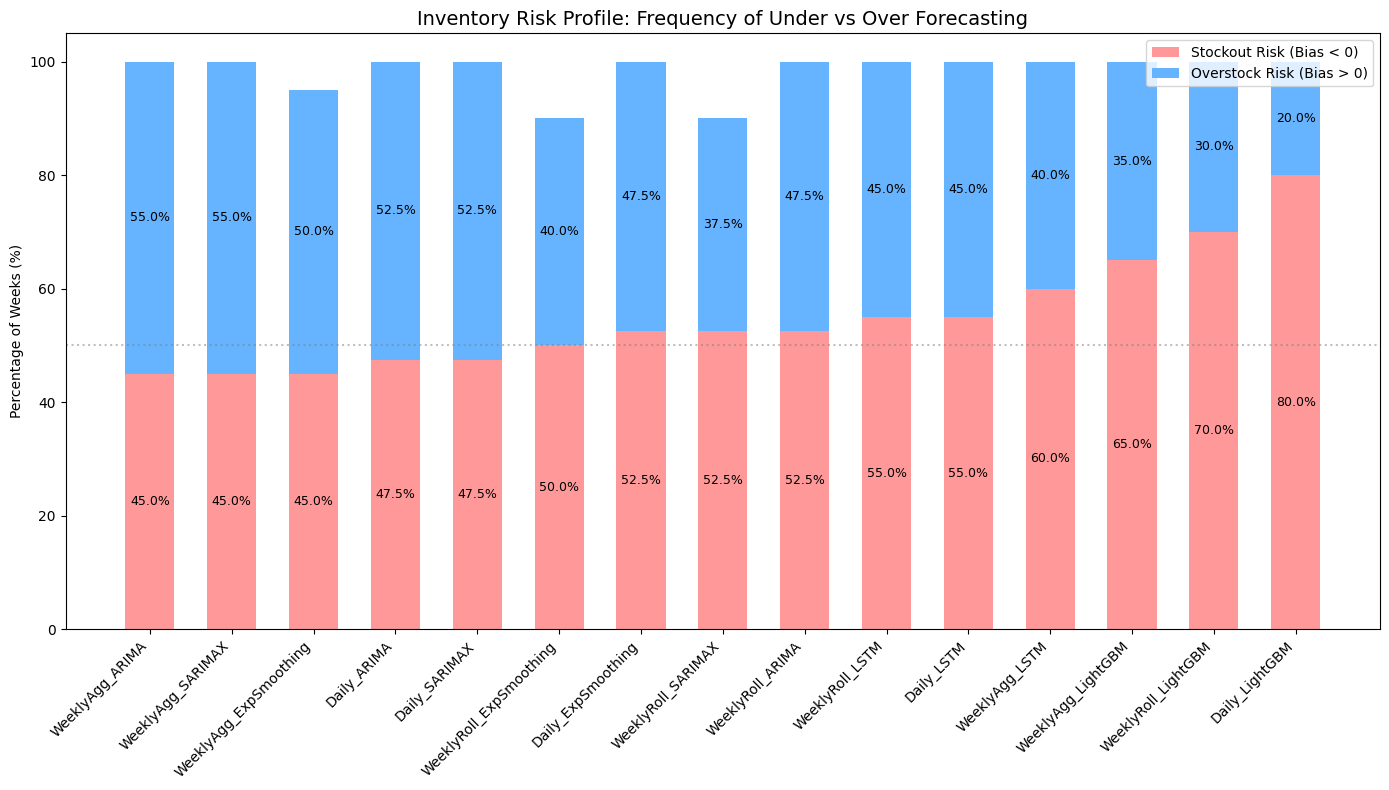

In [55]:
plot_inventory_risk(registry, raw_df, cutoff_date)


=== VISUALIZING ITEM: FOODS_2_010_CA_1_validation ===


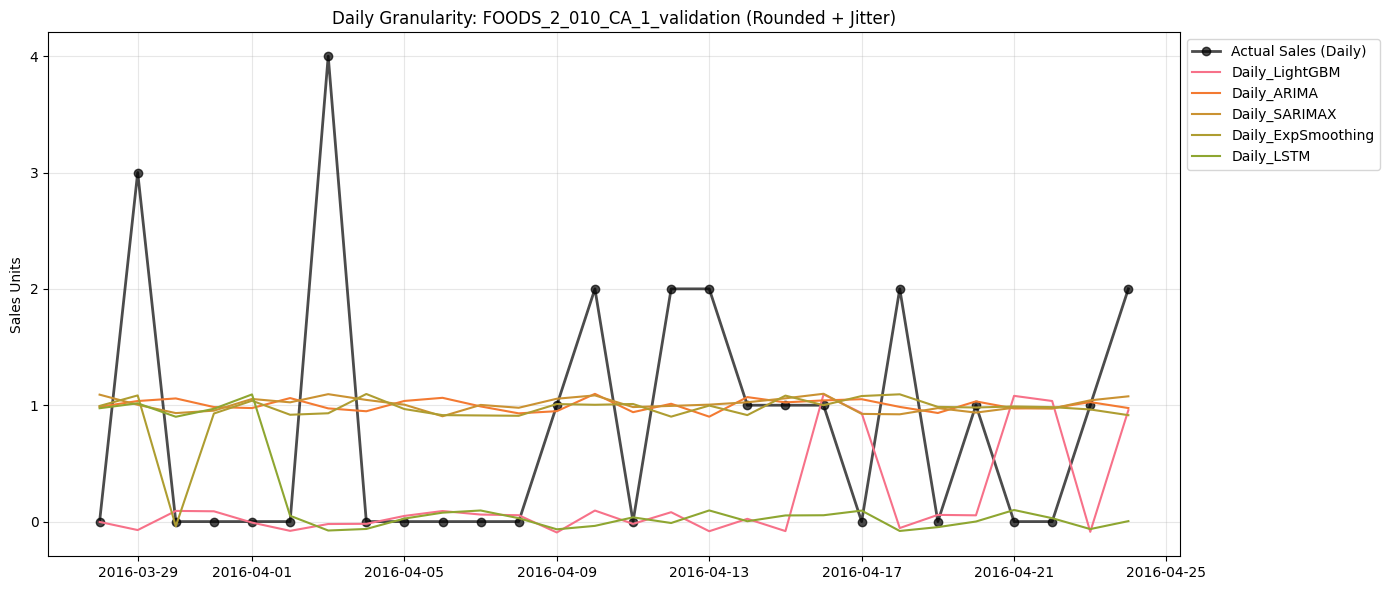

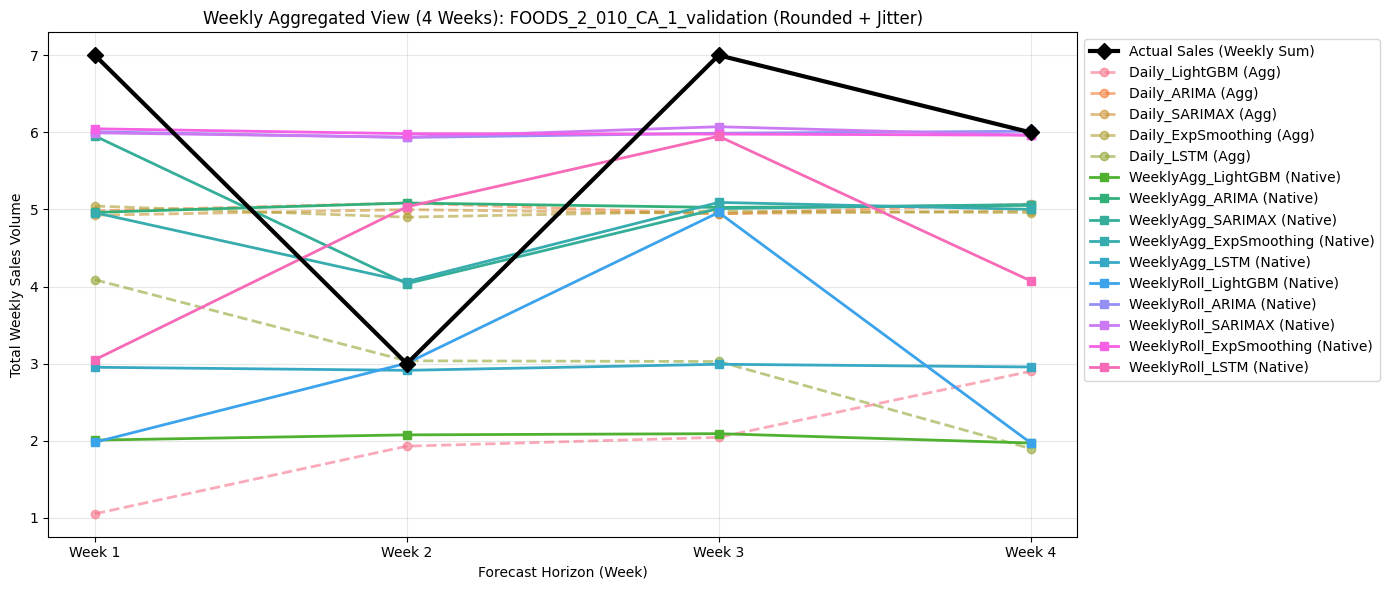

In [56]:
plot_separated_forecasts(registry, raw_df, cutoff_date, sample_id='FOODS_2_010_CA_1_validation')